In [45]:
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.svm
import sklearn.metrics

!wget -nc -O anger-train.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/train.tsv
!wget -nc -O anger-dev.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/dev.tsv
!wget -nc -O anger-test.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/test.tsv

File ‘anger-train.tsv’ already there; not retrieving.
File ‘anger-dev.tsv’ already there; not retrieving.
File ‘anger-test.tsv’ already there; not retrieving.


In [47]:
with open("anger-train.tsv", "r") as f:
  anger_train = pd.read_csv(("anger-train.tsv"), header=0, names=['annotation','text'], sep='\t')

with open("anger-dev.tsv", "r") as f:
  anger_dev = pd.read_csv(("anger-dev.tsv"), header=0, names=['annotation','text'], sep='\t')

train_texts = []
for i in anger_train["text"]:
  train_texts.append(i)
train_labels = []
for i in anger_train["annotation"]:
  train_labels.append(i)

dev_texts = []
for i in anger_dev["text"]:
  dev_texts.append(i)
dev_labels = []
for i in anger_dev["annotation"]:
  dev_labels.append(i)


In [48]:
vectorizer=TfidfVectorizer(max_features=100000,binary=True,ngram_range=(1,1))
feature_matrix_train=vectorizer.fit_transform(train_texts)
feature_matrix_dev=vectorizer.transform(dev_texts)

classifier=sklearn.svm.LinearSVC(C=0.08,verbose=1)
classifier.fit(feature_matrix_train, train_labels)

print("DEV",classifier.score(feature_matrix_dev, dev_labels))
print("TRAIN",classifier.score(feature_matrix_train, train_labels))

predictions_dev=classifier.predict(feature_matrix_dev)
print(predictions_dev)
print(sklearn.metrics.confusion_matrix(dev_labels,predictions_dev))
print(sklearn.metrics.accuracy_score(dev_labels,predictions_dev))

[LibLinear]DEV 0.8012820512820513
TRAIN 0.802434456928839
['not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger'
 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger'
 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger'
 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger'
 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger'
 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger'
 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger'
 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger'
 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger'
 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger'
 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger'
 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger'
 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-anger' 'not-

In [49]:
import tensorflow as tf
import numpy as np

def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

feature_matrix_train_tf=convert_sparse_matrix_to_sparse_tensor(feature_matrix_train)
feature_matrix_dev_tf=convert_sparse_matrix_to_sparse_tensor(feature_matrix_dev)

In [50]:
from sklearn.preprocessing import LabelEncoder

label_encoder=LabelEncoder() #Turns class labels into integers
class_numbers_train=label_encoder.fit_transform(train_labels)
class_numbers_dev=label_encoder.transform(dev_labels)

print("class_numbers shape=",class_numbers_train.shape)
print("class labels",label_encoder.classes_) #this will let us translate back from indices to labels

class_numbers shape= (1068,)
class labels ['anger' 'not-anger']


In [53]:
from keras.models import Model
from keras.layers import Input, Dense

example_count,feature_count=feature_matrix_train.shape #how many examples and features we've got?
example_count2=class_numbers_train.shape[0]
assert example_count==example_count2 #sanity check
class_count=len(label_encoder.classes_) #How many classes we've got?

#Build the network:
inp=Input(shape=(feature_count,)) #Input layer
hidden=Dense(200,activation="tanh")(inp) #Hidden layer
outp=Dense(class_count,activation="softmax")(hidden) #Output layer
model=Model(inputs=[inp], outputs=[outp])

model.compile(optimizer="sgd",loss="sparse_categorical_crossentropy",metrics=['accuracy'])


hist=model.fit(feature_matrix_train_tf,class_numbers_train,\
               validation_data=(feature_matrix_dev_tf,class_numbers_dev),\
               batch_size=100,verbose=1,epochs=10)

Epoch 1/10
11/11 [==============================] - 1s 39ms/step - loss: 0.6799 - accuracy: 0.6868 - val_loss: 0.6446 - val_accuracy: 0.7949
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.6334 - accuracy: 0.8056 - val_loss: 0.6102 - val_accuracy: 0.7949
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.5988 - accuracy: 0.8077 - val_loss: 0.5851 - val_accuracy: 0.7949
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.5733 - accuracy: 0.8079 - val_loss: 0.5662 - val_accuracy: 0.7949
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.5515 - accuracy: 0.8135 - val_loss: 0.5521 - val_accuracy: 0.7949
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.5398 - accuracy: 0.8091 - val_loss: 0.5415 - val_accuracy: 0.7949
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.5359 - accuracy: 0.7991 - val_loss: 0.5333 - val_accuracy: 0.7949
Epoch 8/10
11/11 [=

In [54]:
print(hist.history["val_accuracy"])
# joku häikkä täällä koska kaikissa sama val_accuracy?

[0.7948718070983887, 0.7948718070983887, 0.7948718070983887, 0.7948718070983887, 0.7948718070983887, 0.7948718070983887, 0.7948718070983887, 0.7948718070983887, 0.7948718070983887, 0.7948718070983887]


In [55]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
import os
import pickle

def save_model(file_name,model,label_encoder,vectorizer):
    """Saves model structure and vocabularies"""
    model_json = model.to_json()
    with open(file_name+".model.json", "w") as f:
        print(model_json,file=f)
    with open(file_name+".encoders.pickle","wb") as f:
        pickle.dump((label_encoder,vectorizer),f)
            
example_count,feature_count=feature_matrix_train_tf.shape #how many examples and features we've got?
example_count2=class_numbers_train.shape[0]
assert example_count==example_count2 #sanity check
class_count=len(label_encoder.classes_) #How many classes we've got?

#Build the network:
inp=Input(shape=(feature_count,)) #Input layer
hidden=Dense(200,activation="tanh")(inp) #Hidden layer
outp=Dense(class_count,activation="softmax")(hidden) #Output layer
model=Model(inputs=[inp], outputs=[outp])

# Let's try a different optimizer!
opt=optimizers.Adam()
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])

# Save model and vocabularies, can be done before training
os.makedirs("models",exist_ok=True)
save_model("models/imdb_bow",model,label_encoder,vectorizer)
# Callback function to save weights during training, if validation loss goes down
save_cb=ModelCheckpoint(filepath="models/imdb_bow.weights.h5", monitor='val_loss',\
                        verbose=1, save_best_only=True, mode='auto')
stop_cb=EarlyStopping(patience=2,verbose=1,restore_best_weights=True)
hist=model.fit(feature_matrix_train_tf,class_numbers_train,\
               validation_data=(feature_matrix_dev_tf,class_numbers_dev),\
               batch_size=100,verbose=1,epochs=20,\
               callbacks=[save_cb,stop_cb])

Epoch 1/20
11/11 [==============================] - 1s 22ms/step - loss: 0.6640 - accuracy: 0.6821 - val_loss: 0.5583 - val_accuracy: 0.7949

Epoch 00001: val_loss improved from inf to 0.55827, saving model to models/imdb_bow.weights.h5
Epoch 2/20
11/11 [==============================] - 0s 10ms/step - loss: 0.4927 - accuracy: 0.8058 - val_loss: 0.4726 - val_accuracy: 0.7949

Epoch 00002: val_loss improved from 0.55827 to 0.47260, saving model to models/imdb_bow.weights.h5
Epoch 3/20
11/11 [==============================] - 0s 10ms/step - loss: 0.3801 - accuracy: 0.8010 - val_loss: 0.4435 - val_accuracy: 0.7949

Epoch 00003: val_loss improved from 0.47260 to 0.44352, saving model to models/imdb_bow.weights.h5
Epoch 4/20
11/11 [==============================] - 0s 10ms/step - loss: 0.3193 - accuracy: 0.7995 - val_loss: 0.4297 - val_accuracy: 0.8077

Epoch 00004: val_loss improved from 0.44352 to 0.42972, saving model to models/imdb_bow.weights.h5
Epoch 5/20
11/11 [======================

In [56]:

import numpy
from sklearn.metrics import classification_report, confusion_matrix

#Validation data used during training:
val_instances,val_labels=feature_matrix_dev_tf,class_numbers_dev

print("Network output=",model.predict(val_instances))
predictions=numpy.argmax(model.predict(val_instances),axis=1)
print("Maximum class for each example=",predictions)
gold=val_labels
conf_matrix=confusion_matrix(list(gold),list(predictions))
print("Confusion matrix=\n",conf_matrix)

gold_labels=label_encoder.inverse_transform(list(gold))
predicted_labels=label_encoder.inverse_transform(list(predictions))
#print("Gold labels=",gold_labels)
#print("Predicted labels=",predicted_labels)
print(classification_report(gold_labels,predicted_labels))

Network output= [[0.12829205 0.871708  ]
 [0.14065439 0.8593456 ]
 [0.37152106 0.62847894]
 [0.74835783 0.2516422 ]
 [0.09626552 0.9037345 ]
 [0.29086107 0.70913893]
 [0.3201053  0.6798946 ]
 [0.06716896 0.93283105]
 [0.18236566 0.81763434]
 [0.12333383 0.8766661 ]
 [0.29675487 0.7032451 ]
 [0.05074961 0.94925034]
 [0.13296641 0.8670336 ]
 [0.22753415 0.7724658 ]
 [0.04392664 0.9560734 ]
 [0.14758247 0.85241747]
 [0.26292458 0.7370754 ]
 [0.02285994 0.97714007]
 [0.22646886 0.77353114]
 [0.11659402 0.88340604]
 [0.15437654 0.84562343]
 [0.06017316 0.93982685]
 [0.13962308 0.86037695]
 [0.05165907 0.9483409 ]
 [0.10382106 0.89617896]
 [0.19934137 0.80065864]
 [0.364313   0.635687  ]
 [0.05257065 0.94742936]
 [0.16832186 0.8316781 ]
 [0.10000757 0.8999924 ]
 [0.14064968 0.85935026]
 [0.10269503 0.89730495]
 [0.28696084 0.7130391 ]
 [0.44218165 0.55781835]
 [0.06841051 0.9315894 ]
 [0.29059806 0.70940197]
 [0.07120673 0.92879325]
 [0.03476283 0.9652372 ]
 [0.06994406 0.930056  ]
 [0.17273

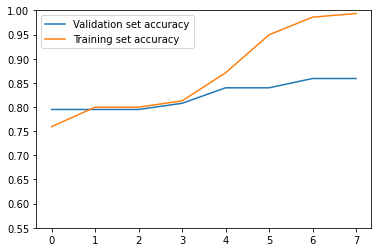

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.ylim(0.55,1.0)
plt.plot(hist.history["val_accuracy"],label="Validation set accuracy")
plt.plot(hist.history["accuracy"],label="Training set accuracy")
plt.legend()
plt.show()